<a href="https://colab.research.google.com/github/milenaonmaui/Udacity_pytorch/blob/master/Less_5_20_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models

In [2]:
!wget -P /datalab https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
!wget https://github.com/udacity/deep-learning-v2-pytorch/blob/master/intro-to-pytorch/helper.py

--2019-12-11 20:35:10--  https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.107.70
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.107.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 580495262 (554M) [application/zip]
Saving to: ‘/datalab/Cat_Dog_data.zip’

Cat_Dog_data.zip    100%[===================>] 553.60M  14.5MB/s    in 41s     

2019-12-11 20:35:52 (13.4 MB/s) - ‘/datalab/Cat_Dog_data.zip’ saved [580495262/580495262]



In [0]:
!unzip -qq /datalab/Cat_Dog_data.zip -d /datalab/


In [6]:
# check if GPU is available
print(torch.cuda.is_available())
!pwd

True
/content


In [0]:
train_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.RandomResizedCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406], 
                                                            [0.229, 0.224, 0.225])])
data_dir = '../datalab/Cat_Dog_data'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


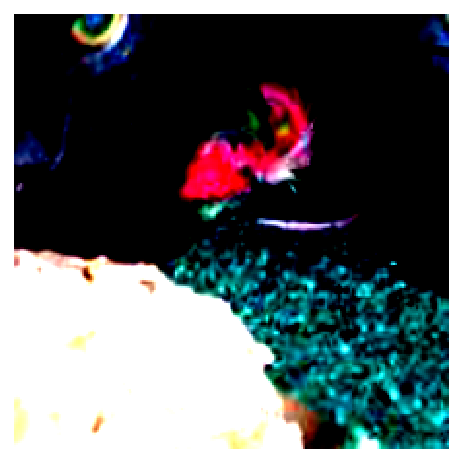

In [15]:
#test dataloader
import helper
images, labels = next(iter(trainloader))
helper.imshow(images[2], normalize=False)

In [16]:
model = models.densenet121(pretrained=True)
model

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 115MB/s]


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [0]:
# Freeze parameters so we don't backprop through them
for param in model.parameters():
    param.requires_grad = False

from collections import OrderedDict
classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(1024, 500)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(500, 2)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))
    
model.classifier = classifier

In [0]:
import time

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
model.to(device)

In [27]:
epochs = 1
steps = 0
running_loss = 0
print_every = 5
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    test_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            model.train()

Epoch 1/1.. Train loss: 0.330.. Test loss: 0.326.. Test accuracy: 0.827
Epoch 1/1.. Train loss: 0.383.. Test loss: 0.334.. Test accuracy: 0.838
Epoch 1/1.. Train loss: 0.347.. Test loss: 0.360.. Test accuracy: 0.829
Epoch 1/1.. Train loss: 0.297.. Test loss: 0.375.. Test accuracy: 0.825
Epoch 1/1.. Train loss: 0.296.. Test loss: 0.324.. Test accuracy: 0.839
Epoch 1/1.. Train loss: 0.358.. Test loss: 0.329.. Test accuracy: 0.847
Epoch 1/1.. Train loss: 0.411.. Test loss: 0.352.. Test accuracy: 0.831
Epoch 1/1.. Train loss: 0.543.. Test loss: 0.378.. Test accuracy: 0.834
Epoch 1/1.. Train loss: 0.524.. Test loss: 0.362.. Test accuracy: 0.837
Epoch 1/1.. Train loss: 0.433.. Test loss: 0.346.. Test accuracy: 0.841
Epoch 1/1.. Train loss: 0.537.. Test loss: 0.380.. Test accuracy: 0.826
Epoch 1/1.. Train loss: 0.489.. Test loss: 0.392.. Test accuracy: 0.827
Epoch 1/1.. Train loss: 0.433.. Test loss: 0.384.. Test accuracy: 0.823
Epoch 1/1.. Train loss: 0.310.. Test loss: 0.380.. Test accuracy